In [1]:
 ! pip install -q kaggle

In [2]:
from google.colab import files 

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{}'}

In [4]:
! mkdir ~/.kaggle 

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
 ! kaggle datasets list

ref                                                     title                                         size  lastUpdated          downloadCount  
------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
manchunhui/us-election-2020-tweets                      US Election 2020 Tweets                      353MB  2020-11-09 18:51:59           1289  
unanimad/us-election-2020                               US Election 2020                             417KB  2020-11-09 13:52:09           1340  
headsortails/us-election-2020-presidential-debates      US Election 2020 - Presidential Debates      199MB  2020-10-23 16:56:10            301  
antgoldbloom/covid19-data-from-john-hopkins-university  COVID-19 data from John Hopkins University     2MB  2020-11-09 06:07:13             82  
etsc9287/2020-general-election-polls                    2020 General Election Polls                  109KB  2020-02-09 08:20:59   

In [9]:
!kaggle competitions download -c digit-recognizer

 87% 8.00M/9.16M [00:00<00:00, 81.4MB/s]
100% 9.16M/9.16M [00:00<00:00, 84.2MB/s]
 82% 5.00M/6.09M [00:00<00:00, 35.0MB/s]
100% 6.09M/6.09M [00:00<00:00, 38.7MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 69.9MB/s]


In [10]:
! mkdir train

In [12]:
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [13]:
!mkdir test

In [14]:
! unzip test.csv.zip -d test

Archive:  test.csv.zip
  inflating: test/test.csv           


In [17]:
# Basic Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import TensorDataset
from torch.optim import Adam, SGD

# Basic Numeric Computation
import numpy as np
import pandas as pd

# Look at data
from matplotlib import pyplot

# Easy way to split train data
from sklearn.model_selection import train_test_split

# # Looking at directory
# import os
# base_dir = "../input"
# print(os.listdir(base_dir))

device = torch.device("cpu")# if torch.cuda.is_available() else torch.device("cpu")
device
epochs=12

In [19]:
train = pd.read_csv('/content/train/train.csv')
test = pd.read_csv('/content/test/test.csv')

In [20]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2. transform

In [21]:
# Convert Dataframe into format ready for training
def createImageData(raw: pd.DataFrame):
    y = raw['label'].values
    y.resize(y.shape[0],1)
    x = raw[[i for i in raw.columns if i != 'label']].values
    x = x.reshape([-1,1, 28, 28])
    y = y.astype(int).reshape(-1)
    x = x.astype(float)
    return x, y

## Convert to One Hot Encoding
def one_hot_embedding(labels, num_classes=10):
    y = torch.eye(num_classes) 
    return y[labels] 

In [22]:
x_train, y_train = createImageData(train)
#x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.02)

#x_train.shape, y_train.shape, x_val.shape, y_val.shape
x_train.shape, y_train.shape

((42000, 1, 28, 28), (42000,))

In [23]:
# Normalization
mean = x_train.mean()
std = x_train.std()
x_train = (x_train-mean)/std
#x_val = (x_val-mean)/std

# Numpy to Torch Tensor
x_train = torch.from_numpy(np.float32(x_train)).to(device)
y_train = torch.from_numpy(y_train.astype(np.long)).to(device)
y_train = one_hot_embedding(y_train)
#x_val = torch.from_numpy(np.float32(x_val))
#y_val = torch.from_numpy(y_val.astype(np.long))

# 3. Load

In [24]:
# Convert into Torch Dataset
train_ds = TensorDataset(x_train, y_train)
#val_ds = TensorDataset(x_val,y_val)

In [25]:
# Make Data Loader
train_dl = DataLoader(train_ds, batch_size=64)

## EDA

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


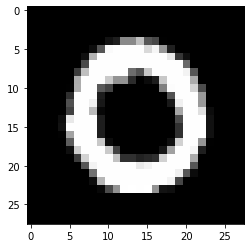

In [26]:
index = 1
pyplot.imshow(x_train.cpu()[index].reshape((28, 28)), cmap="gray")
print(y_train[index])

## MOdel

In [27]:
# Helper Functions

## Initialize weight with xavier_uniform
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

## Flatten Later
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

# Train the network and print accuracy and loss overtime
def fit(train_dl, model, loss, optim, epochs=10):
    model = model.to(device)
    print('Epoch\tAccuracy\tLoss')
    accuracy_overtime = []
    loss_overtime = []
    for epoch in range(epochs):
        avg_loss = 0
        correct = 0
        total=0
        for x, y in train_dl: # Iterate over Data Loder
    
            # Forward pass
            yhat = model(x) 
            l = loss(y, yhat)
            
            #Metrics
            avg_loss+=l.item()
            
            # Backward pass
            optim.zero_grad()
            l.backward()
            optim.step()
            
            # Metrics
            _, original =  torch.max(y, 1)
            _, predicted = torch.max(yhat.data, 1)
            total += y.size(0)
            correct = correct + (original == predicted).sum().item()
            
        accuracy_overtime.append(correct/total)
        loss_overtime.append(avg_loss/len(train_dl))
        print(epoch,accuracy_overtime[-1], loss_overtime[-1], sep='\t')
    return accuracy_overtime, loss_overtime

# Plot Accuracy and Loss of Model
def plot_accuracy_loss(accuracy, loss):
    f = pyplot.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.title.set_text("Accuracy over epochs")
    ax2.title.set_text("Loss over epochs")
    ax1.plot(accuracy)
    ax2.plot(loss, 'r:')

# Take an array and show what model predicts 
def predict_for_index(array, model, index):
    testing = array[index].view(1,28,28)
    pyplot.imshow(x_train[index].reshape((28, 28)), cmap="gray")
    print(x_train[index].shape)
    a = model(testing.float())
    print('Prediction',torch.argmax(a,1))

In [28]:
# Define the model

ff_model = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax(1),
).to(device)

In [29]:
# Initialize model with xavier initialization which is recommended for ReLu
ff_model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
  (4): Softmax(dim=1)
)

Epoch	Accuracy	Loss
0	0.9070476190476191	0.013667682191970811
1	0.9577142857142857	0.006563970649066431
2	0.9688333333333333	0.004935050102914159
3	0.9768095238095238	0.0038218928349876007
4	0.9801428571428571	0.003255577986532627
5	0.9834285714285714	0.002722567654970757
6	0.9863571428571428	0.002326337982528403
7	0.9872380952380952	0.0021555991658734047
8	0.9878809523809524	0.0019994406545720267
9	0.9885952380952381	0.0018727844953365877
10	0.989547619047619	0.0017084493914981042
11	0.9913095238095239	0.0014923217874675437


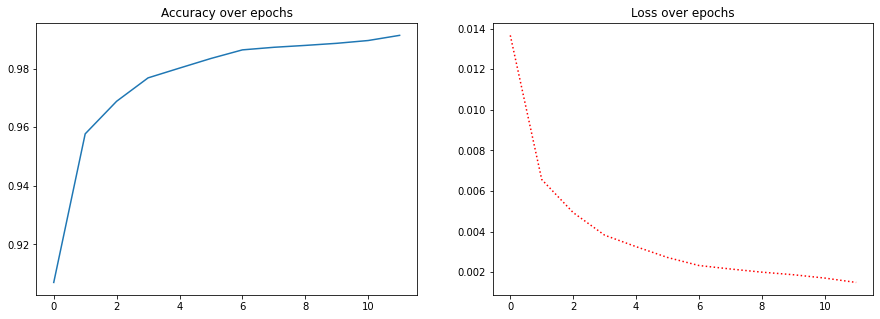

In [30]:
optim = Adam(ff_model.parameters())
loss = nn.MSELoss()
output = fit(train_dl, ff_model, loss, optim, epochs)
plot_accuracy_loss(*output)

torch.Size([1, 28, 28])
Prediction tensor([0])


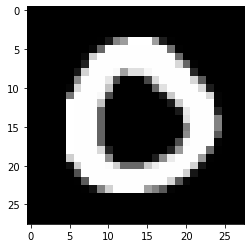

In [31]:
index = 4
predict_for_index(x_train, ff_model, index)

In [32]:
# A too simple NN taken from pytorch.org/tutorials
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.average1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.average2 = nn.AvgPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4, stride=1)
        
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(120, 82)
        self.fc2 = nn.Linear(82,10)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.tanh(self.conv1(xb))
        xb = self.average1(xb)
        xb = F.tanh(self.conv2(xb))
        xb = self.average2(xb)
        xb = F.tanh(self.conv3(xb))
        xb = xb.view(-1, xb.shape[1])
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.fc2(xb))
        return xb

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch	Accuracy	Loss
0	0.8295	0.024257624548075996
1	0.8807142857142857	0.01573720137351951
2	0.8872380952380953	0.014220154276146034
3	0.8907142857142857	0.013434058933092147
4	0.8926666666666667	0.012940065951555786
5	0.8939047619047619	0.012577981816015037
6	0.8947380952380952	0.012296840460273569
7	0.8956666666666667	0.012080316865941456
8	0.8961904761904762	0.01189652137327911
9	0.8965714285714286	0.011736341546568878
10	0.8971190476190476	0.011606817156759685
11	0.8975238095238095	0.011493785651981876


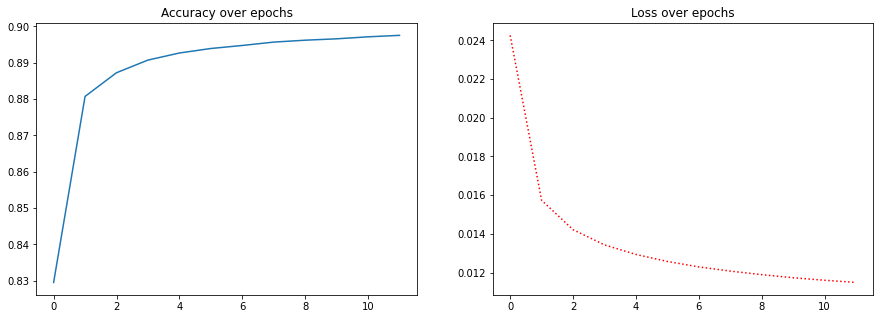

In [33]:
conv_model = LeNet5()
conv_model.apply(init_weights)
loss = nn.MSELoss()
optim = SGD(conv_model.parameters(), lr=0.1, momentum=0.9)
plot_accuracy_loss(*fit(train_dl, conv_model,loss,optim,epochs))

## Working on test data

### Normalization

In [34]:
x_test = test.values
x_test = x_test.reshape([-1, 28, 28]).astype(float)
x_test = (x_test-mean)/std
x_test = torch.from_numpy(np.float32(x_test))
x_test.shape

torch.Size([28000, 28, 28])

#### Prediction

torch.Size([1, 28, 28])
Prediction tensor([3])
torch.Size([1, 28, 28])
Prediction tensor([3])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


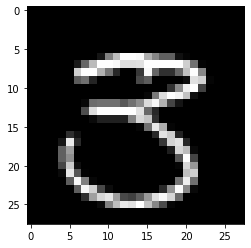

In [35]:
index = 7
predict_for_index(x_test, ff_model, index)
predict_for_index(x_test, conv_model, index)

In [36]:
# Export data to CSV in format of submission
def export_csv(model_name, predictions, commit_no):
    df = pd.DataFrame(prediction.tolist(), columns=['Label'])
    df['ImageId'] = df.index + 1
    file_name = f'submission_{model_name}_v{commit_no}.csv'
    print('Saving ',file_name)
    df[['ImageId','Label']].to_csv(file_name, index = False)

In [37]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
# just to make output easier to read
commit_no = 17

In [39]:
ff_test_yhat = ff_model(x_test.float())
prediction = torch.argmax(ff_test_yhat,1)
print('Prediction',prediction)
export_csv('ff_model',prediction, commit_no=commit_no)

Prediction tensor([2, 0, 9,  ..., 3, 9, 2])
Saving  submission_ff_model_v17.csv


In [40]:
cn_train_yhat = conv_model(x_test)
prediction = torch.argmax(cn_train_yhat,1)
yo = torch.argmax(y_train,1)
export_csv('lenet_model',prediction, commit_no=commit_no)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Saving  submission_lenet_model_v17.csv


### Ensembling

In [41]:
models = []
optims = []
loss = nn.MSELoss()
ensembles = 15
import sys
for i in range(ensembles):
    sys.stdout.write(f'Ensemble No {i+1}\n')
    model = LeNet5()
    model.apply(init_weights)
    #optim = Adam(model.parameters())
    optim = SGD(model.parameters(), lr=0.1, momentum=0.9)

    accuracy, _ = fit(train_dl, model,loss,optim,epochs)
    if accuracy[-1] > 95:
        models.append(model)
        optims.append(optim)

Ensemble No 1
Epoch	Accuracy	Loss


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0	0.9111428571428571	0.016511163488243063
1	0.9700238095238095	0.007111747115510239
2	0.9797380952380952	0.005202083471174461
3	0.9842619047619048	0.004263598822100482
4	0.9865238095238095	0.003668796987828474
5	0.9885714285714285	0.0032527321415189285
6	0.9895	0.002938218746886091
7	0.9904285714285714	0.002678092770890476
8	0.9911904761904762	0.002474854236732335
9	0.9917142857142857	0.0023038261132371503
10	0.9921904761904762	0.002157256974708615
11	0.9927142857142857	0.0020299362510590156
Ensemble No 2
Epoch	Accuracy	Loss
0	0.9172619047619047	0.01556841353070745
1	0.9723095238095238	0.006644158197788003
2	0.9799285714285715	0.004954955967010638
3	0.9838333333333333	0.004082293982533922
4	0.9864285714285714	0.003539374203345337
5	0.9879523809523809	0.00315711912165695
6	0.9893095238095239	0.0028619879904193193
7	0.9900238095238095	0.002624628800757745
8	0.9909523809523809	0.002428901577410905
9	0.9915714285714285	0.002260973717438984
10	0.9922380952380953	0.0021149535993712316
11	0.9

In [43]:
ensemble = cn_train_yhat

for model in models:
    ensemble+=model(x_test)

ensemble_one_hot = torch.argmax(ensemble,1) # Find argmax
export_csv(f'ensemble_{ensembles}_LeNets',ensemble_one_hot, commit_no=commit_no)

Saving  submission_ensemble_15_LeNets_v17.csv


In [44]:
ensemble_one_hot

tensor([2, 0, 9,  ..., 3, 9, 2])

In [46]:
ensemble = ff_test_yhat + cn_train_yhat # Add probabilities of individual predictions
ensemble_one_hot = torch.argmax(y_train,1) # Find argmax
export_csv('ensemble',ensemble_one_hot, commit_no=commit_no)

Saving  submission_ensemble_v17.csv
